# Sequence and structure I: foundations and early work

## Contact prediction from correlations

Protein structure can affect function, and therefore the "fitness" or reproductive success of an organism. Evolution should therefore preserve (functionally important) structural features. 

Pairs of amino acids in close contact provide one example. If a mutation changes one of these residues, the other might also need to change to rescue function. If we look at widely diverged protein sequences, evidence for contact pairs should therefore appear in correlated substitutions at those sites.

For more information, consider reviews by [Marks et al, Nature Biotechnology 2012](https://doi.org/10.1038/nbt.2419) or [Cocco et al, Reports on Progress in Physics 2018](https://doi.org/10.1088/1361-6633/aa9965).

### Example: uncovering structure in trypsin inhibitor proteins

To show how this works in practice, we'll examine a sequence alignment for trypsin inhibitor proteins ([protein family PF00014](https://www.ebi.ac.uk/interpro/entry/pfam/PF00014) in the PFAM database). Here is an example of the protein structure, taken from [PDB entry 5PTI](https://www.rcsb.org/structure/5PTI).

![5PTI](data/5pti_structure.jpeg)

We'll start by reading in the 5PTI PDB file using [BioPython](https://biopython.org/) and computing the pairwise distance between each pair of amino acids in the folded structure.

In [1]:
# First, let's import the libraries that we'll need
from Bio import PDB              # BioPython for PDB files
import matplotlib.pyplot as plt  # matplotlib for plots
import numpy as np               # numpy for vectors/matrices and math
import copy                      # for copying data structures by value
import figs                      # a helper file for making figures

In [2]:
# This is a data structure that stores information from PDB files
structure = PDB.PDBParser().get_structure('PF00014', 'data/pdb5pti.ent') 

# The structure is a bit complicated, but we just need a few elements
# The code below extracts a list of amino acids (and their positions, etc)
# from the PDB file
model = structure[0]
chain = model['A']
residues = [r for r in chain if PDB.is_aa(r)]

/opt/homebrew/Caskroom/mambaforge/base/lib/python3.10/site-packages/Bio/PDB/Atom.py:232: PDBConstructionWarning: Used element 'U' for Atom (name=UNK) with given element 'X'
  warnings.warn(msg, PDBConstructionWarning)


In [3]:
# The sequence alignment we'll be using omits the first three sites
# and the last two sites of the structure, so we should remove those
residues = residues[3:-2]
L = len(residues)

print('The sequence is %d amino acids long' % L)

The sequence is 53 amino acids long


In [4]:
# Now we'll compute the LxL distance matrix for the remaining sites
d_mat = np.zeros((L, L))
for i in range(L):
    for j in range(i+1, L):
        # Getting the distance is easy, we just "subtract" the residues
        # from each other, which returns a distance in Angstroms
        # Here we use the carbon alpha atoms as a reference for distance
        distance = residues[i]['CA'] - residues[j]['CA']
        d_mat[i, j] = distance
        d_mat[j, i] = distance

### Setting our expectations

Now that we have the distance matrix, we can set a threshold for the maximum distance between residues that we consider to be "in contact." In this example, we'll use a distance of 8 Angstroms.

To calibrate our expecations, let's check the accuracy of randomly choosing contact sites.

In [5]:
# We'll make lists to hold the pairs of sites that we predict to be in contact
# In this case, our predictor is random
pred_pairs = []
pred_vals = []
for i in range(L):
    for j in range(i+1, L):
        pred_pairs.append((i, j))
        pred_vals.append(np.random.rand())

In [6]:
# Before we make a plot, we need to define which residues are in contact
contact_cutoff = 8
contacts = []
for i in range(L):
    for j in range(i+1, L):
        if d_mat[i, j]<contact_cutoff:
            contacts.append((i, j))

In [7]:
# Now, we'll take the top 50 predictions and sort pairs of sites into 
# true positives (correctly predicted contact), false positives (incorrect),
# and other contact sites -- to make it easier for later we'll write a function

def get_contact_predictions(contacts, pred_vals, pred_pairs, n_predictions=50):
    pred_sort = np.argsort(pred_vals)[::-1]
    
    true_positive = []
    false_positive = []
    for i in range(n_predictions):
        pair = pred_pairs[pred_sort[i]]
        if pair in contacts:
            true_positive.append(pair)
        else:
            false_positive.append(pair)
    
    other_contacts = []
    for pair in contacts:
        if (pair not in true_positive) and (pair not in false_positive):
            other_contacts.append(pair)

    return true_positive, false_positive, other_contacts

In [8]:
# How good are random predictions? Let's check
true_positive, false_positive, other_contacts = get_contact_predictions(contacts, pred_vals, pred_pairs)
print('%d true positives, %d false positives in top %d predictions' 
      % (len(true_positive), len(false_positive), len(true_positive)+len(false_positive)))

13 true positives, 37 false positives in top 50 predictions


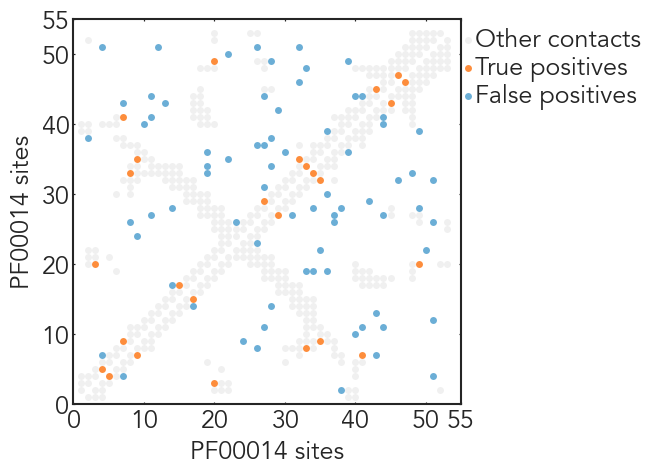

In [9]:
# It's random, but most likely: _yikes_
# Here's what the random contact plot looks like
figs.contact_plot_PF00014(other_contacts, true_positive, false_positive)
plt.show()

### Reading in the PF00014 alignment and computing correlations

Surely, we can do better than randomly guessing contact pairs. 

Let's use amino acid covariation to try to predict contacts. To do this, we should read in an alignment of protein sequences from the same family ([PF00014](https://www.ebi.ac.uk/interpro/entry/pfam/PF00014)) and analyze them. In this case, we'll just use `numpy` and a little bit of Python directly to compute the correlations.

In [10]:
# First we should include a list of amino acids
# We'll use the position in this list to map amino acids to numerical values
aas = ['A', 'R', 'N', 'D', 'C', 'Q', 'E', 'G', 'H', 'I',
       'L', 'K', 'M', 'F', 'P', 'S', 'T', 'W', 'Y', 'V', '-']

# Now we'll read in the sequences -- lines that start with '>' are labels,
# and the rest are the sequences
alignment = [list(i.split()[0]) for i in open('data/PF00014-alignment.fasta').readlines() if i[0]!='>']
alignment = np.array(alignment)

# Let's make sure that it looks right
shape = alignment.shape
print('Found %d sequences of length %d' % (shape[0], shape[1]))
print('The first sequence is %s' % ''.join(alignment[0]))

Found 4915 sequences of length 53
The first sequence is VCELPVVFGVGSSQLVRYYYDRKSNQCLQFTYGGSKGNQNNFKTFNECEKTC-


In [11]:
# Now, let's transform the sequences from lists of amino acids to 
# one-hot encoded vectors (#AAs * #sites in length)
num_aas = len(aas)
num_seqs = shape[0]
num_sites = shape[1]

alignment_onehot = np.zeros((num_seqs, num_aas*num_sites))
for i in range(num_seqs):
    for j in range(num_sites):
        alignment_onehot[i][(j*len(aas)) + aas.index(alignment[i][j])] = 1

In [12]:
# Use numpy to compute covariances between amino acids at different sites
cov = np.cov(alignment_onehot.T)

# Now we get the top predicted contacts, which will be the pairs of *sites*
# where amino acids are most strongly covarying
pred_sites = []
pred_vals = []
for i in range(num_sites):
    for j in range(i+1, num_sites):
        pred_sites.append((i, j))
        # Take the submatrix of covariances between AAs at sites i and j,
        # square them, and take the sum
        pred_vals.append(np.sum(cov[num_aas*i:num_aas*(i+1), num_aas*j:num_aas*(j+1)]**2))

### Predicting contacts from amino acid covariation

If we are correct that important structural contacts can produce amino acid covariation, then the pairs of sites that exhibit the most covariation should be more likely to be in contact. Below, we'll test how well this works by using the squared covariances between pairs of sites as contact predictors.

In [13]:
# How do these compare to random predictions?
true_positive, false_positive, other_contacts = get_contact_predictions(contacts, pred_vals, pred_pairs)
print('%d true positives, %d false positives in top %d predictions' 
      % (len(true_positive), len(false_positive), len(true_positive)+len(false_positive)))

30 true positives, 20 false positives in top 50 predictions


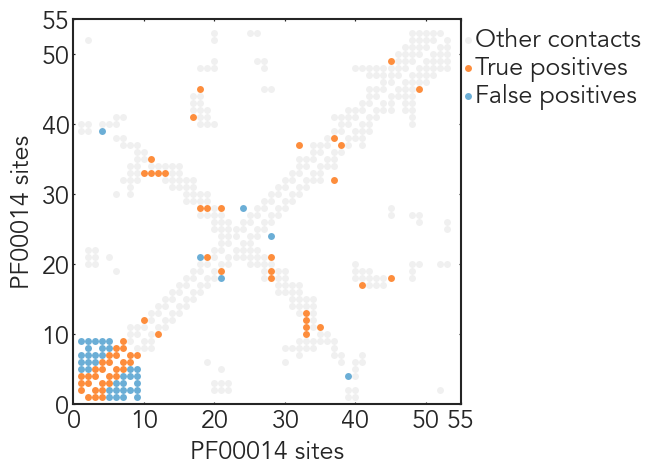

In [14]:
# Much better! Let's look at the contact plot
figs.contact_plot_PF00014(other_contacts, true_positive, false_positive)
plt.show()

## Amino acid covariation and structure are not the same

As we just discussed, not all structural features will show up in correlations, and not all correlations are due to structure. For example, contacts that have no effect on function are not targets of natural selection, and thus there will be no evolutionary pressure to preserve them over long times. On the other side, correlations can be generated by many sources that have nothing to do with protein structure.

### Example: random correlations due to phylogeny

One force that generates correlations without structural association is [phylogeny](https://en.wikipedia.org/wiki/Phylogenetic_tree), i.e., the shared evolutionary history between organisms. To see how this happens, we can run a simple simulation, inspired by [Qin and Colwell, PNAS 2018](https://doi.org/10.1073/pnas.1711913115).

We'll begin with an artificial sequence with $L=100$ sites. We'll then introduce $m=5$ random mutations in the sequence before a branching event. At the branch, we'll make two copies of the sequence, which will then evolve independently, gaining $m$ mutations before they branch again, and so on. We'll allow the simulation to branch 14 times, generating $2^{14} = 16384$ sequences at the end. Then, from a random subsample of 1000 of these sequences, we'll compute the correlations between variation at each site and plot them.

In [15]:
# Set out the amino acids and sites in the artificial protein
aas = ['A', 'R', 'N', 'D', 'C', 'Q', 'E', 'G', 'H', 'I',
       'L', 'K', 'M', 'F', 'P', 'S', 'T', 'W', 'Y', 'V']
num_aas = len(aas)
num_sites = 100

# Generate a random starting sequence
starting_seq = np.random.choice(aas, size=num_sites)

In [16]:
# Set the simulation parameters, including the branch length and number of branches
branch_length = 5
n_branches = 14

# Run the simulation and record the sequences
alignment = [starting_seq]
for n in range(n_branches):
    # Duplicate the sequences
    alignment += copy.deepcopy(alignment)
    # Evolve each sequence
    for i in range(len(alignment)):
        rand_sites = np.random.choice(num_sites, size=branch_length)
        rand_aas = np.random.choice(aas, size=branch_length)
        for j in range(branch_length):
            alignment[i][rand_sites[j]] = rand_aas[j]

In [17]:
# Choose a random subset of sequences for analysis
n_subset = 1000
random_seqs = [alignment[i] for i in np.random.choice(len(alignment), size=n_subset)]

In [18]:
# Now we'll use one-hot encoding to compute the correlations
random_seqs = np.array([list(s) for s in random_seqs])
shape = random_seqs.shape
num_seqs = shape[0]
num_sites = shape[1]

alignment_onehot = np.zeros((num_seqs, num_aas*num_sites))
for i in range(num_seqs):
    for j in range(num_sites):
        alignment_onehot[i][(j*len(aas)) + aas.index(random_seqs[i][j])] = 1

In [19]:
# Use numpy to compute covariances between amino acids at different sites
cov = np.cov(alignment_onehot.T)

# And then compute the matrix of correlations between pairs of sites
corrs = np.zeros((num_sites, num_sites))
for i in range(num_sites):
    for j in range(i+1, num_sites):
        c = np.sum(cov[num_aas*i:num_aas*(i+1), num_aas*j:num_aas*(j+1)]**2)
        corrs[i, j] = c
        corrs[j, i] = c

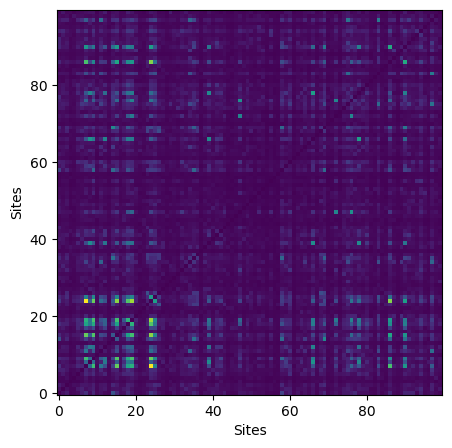

In [20]:
# Finally, let's plot the correlations
fig, ax = plt.subplots(figsize=(5, 5))
im = ax.imshow(corrs, origin='lower')
plt.xlabel('Sites')
plt.ylabel('Sites')
plt.show()

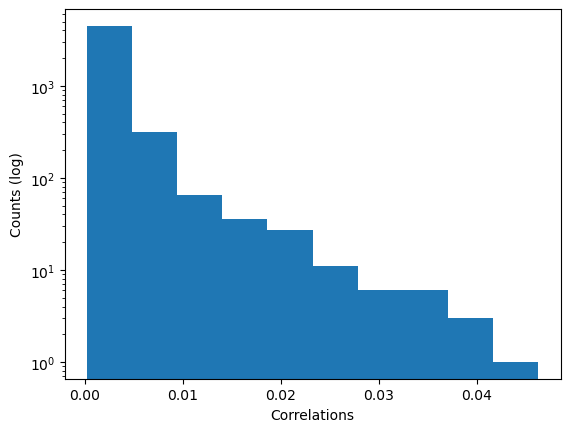

In [21]:
# It looks like there's structure! 
# Are there some correlations that are really outliers? Yes.
corr_upperdiag = [corrs[i][j] for i in range(num_sites) for j in range(i+1, num_sites)]
plt.hist(corr_upperdiag)
plt.yscale('log')
plt.xlabel('Correlations')
plt.ylabel('Counts (log)')
plt.show()